## Overview


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

Starting training...
Epoch [10/150], Total Loss: 0.7342, Coords: 0.5832, TimeOrder: 0.0000, Timelike: 0.0024, AlmostNull: 0.0139
Epoch [20/150], Total Loss: 0.6753, Coords: 0.5942, TimeOrder: 0.0000, Timelike: 0.0007, AlmostNull: 0.0078
Epoch [30/150], Total Loss: 0.6600, Coords: 0.5978, TimeOrder: 0.0000, Timelike: 0.0004, AlmostNull: 0.0060
Epoch [40/150], Total Loss: 0.6657, Coords: 0.5982, TimeOrder: 0.0000, Timelike: 0.0005, AlmostNull: 0.0065
Epoch [50/150], Total Loss: 0.6599, Coords: 0.5966, TimeOrder: 0.0000, Timelike: 0.0003, AlmostNull: 0.0062
Epoch [60/150], Total Loss: 0.6687, Coords: 0.6040, TimeOrder: 0.0000, Timelike: 0.0005, AlmostNull: 0.0062
Epoch [70/150], Total Loss: 0.6769, Coords: 0.5965, TimeOrder: 0.0000, Timelike: 0.0007, AlmostNull: 0.0077
Epoch [80/150], Total Loss: 0.6739, Coords: 0.5952, TimeOrder: 0.0000, Timelike: 0.0007, AlmostNull: 0.0075
Epoch [90/150], Total Loss: 0.6793, Coords: 0.6001, TimeOrder: 0.0000, Timelike: 0.0007, AlmostNull: 0.0076
Epoch [

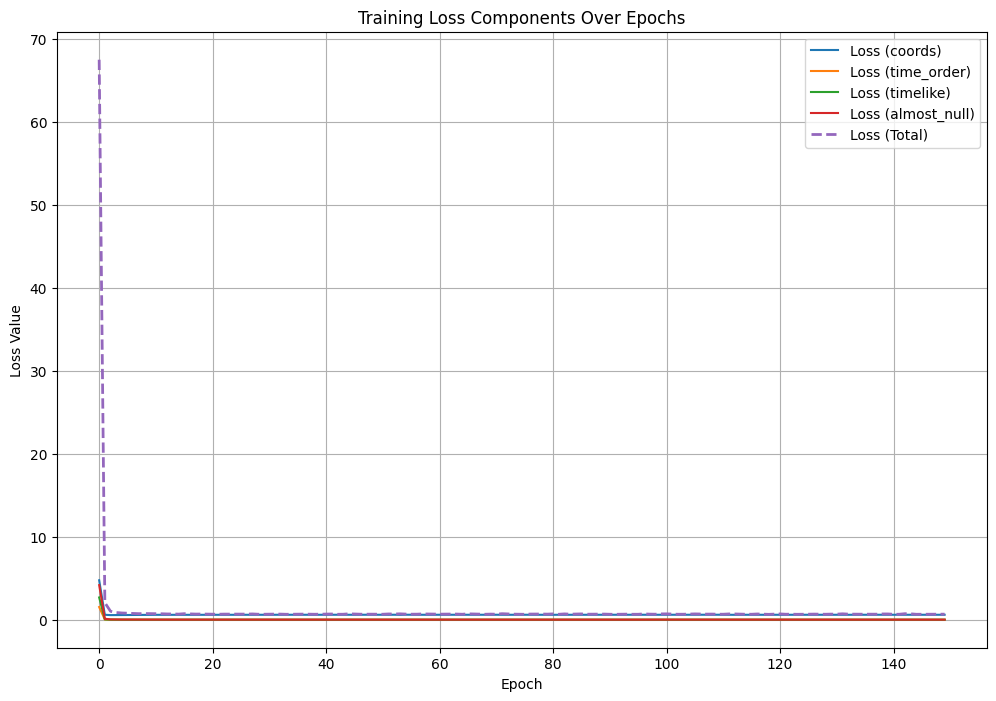


--- Sample Predictions ---

Sample 1:
  Parent P:       t=3.29, x=3.24, y=-1.11
  Child C_gt:     t=4.44, x=3.91, y=-2.03 (Δs²_gt=-0.0100)
  Child C_pred:   t=3.43, x=3.20, y=-1.10 (Δs²_pred=-0.0170, dt_pred=0.14)
  Pred Validations: TimeOrdered=True, Timelike=True, CloseToTargetNull=True

Sample 2:
  Parent P:       t=4.69, x=-0.73, y=2.29
  Child C_gt:     t=5.73, x=-0.35, y=3.25 (Δs²_gt=-0.0100)
  Child C_pred:   t=4.80, x=-0.71, y=2.25 (Δs²_pred=-0.0105, dt_pred=0.11)
  Pred Validations: TimeOrdered=True, Timelike=True, CloseToTargetNull=True

Sample 3:
  Parent P:       t=3.41, x=1.85, y=4.34
  Child C_gt:     t=4.27, x=1.03, y=4.59 (Δs²_gt=-0.0100)
  Child C_pred:   t=3.55, x=1.82, y=4.27 (Δs²_pred=-0.0149, dt_pred=0.14)
  Pred Validations: TimeOrdered=True, Timelike=True, CloseToTargetNull=True

Sample 4:
  Parent P:       t=1.46, x=-3.95, y=1.47
  Child C_gt:     t=2.21, x=-3.79, y=0.74 (Δs²_gt=-0.0100)
  Child C_pred:   t=1.60, x=-3.89, y=1.38 (Δs²_pred=-0.0075, dt_pred=0.14)

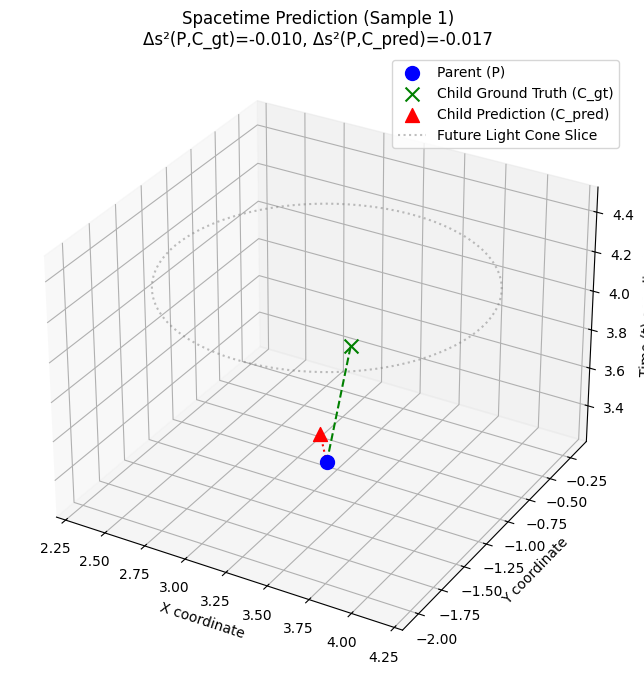


--- 'Quantum Fluctuation' Demo (Noise on Parent Input) ---
  P_noisy: t=3.29, x=3.30, y=-1.12
  C_pred (from P_noisy): t=3.43, x=3.26, y=-1.12 (Δs²=-0.0168)
  P_noisy: t=3.29, x=3.23, y=-1.21
  C_pred (from P_noisy): t=3.43, x=3.19, y=-1.21 (Δs²=-0.0166)
  P_noisy: t=3.29, x=3.23, y=-1.17
  C_pred (from P_noisy): t=3.43, x=3.19, y=-1.16 (Δs²=-0.0167)


In [2]:
# --- Hyperparameters ---
N_SAMPLES = 2000  # Number of training samples
N_EPOCHS = 150  # Number of training epochs
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
HIDDEN_DIM = 64

# Loss function weights
W_COORDS = 1.0  # Weight for coordinate matching loss
W_TIME_ORDER = 5.0  # Weight for ensuring t_child > t_parent
W_TIMELIKE = 5.0  # Weight for ensuring interval is timelike
W_ALMOST_NULL = 10.0  # Weight for ensuring interval is "almost null"

# Geometric parameters for loss
EPSILON_TIME_ORDER = (
    1e-3  # Child's time must be at least this much greater than parent's
)
EPSILON_TIMELIKE = 1e-3  # -(delta_s_squared) must be at least this for timelike
TARGET_DELTA_S_SQUARED = (
    -0.01
)  # The target value for delta_s_squared (a small negative number)
# This relates to epsilon in your L_almost_null description.
# If Δs² = -ε', then this is -ε'.


# --- Helper Function for Minkowski Interval ---
def calculate_delta_s_squared(p_coords, c_coords):
    """
    Calculates the squared Minkowski interval (Δs²) between parent and child.
    p_coords: (batch_size, 3) or (3,) tensor [t, x, y]
    c_coords: (batch_size, 3) or (3,) tensor [t, x, y]
    Returns: (batch_size,) or scalar tensor
    """
    if p_coords.ndim == 1:
        p_coords = p_coords.unsqueeze(0)
    if c_coords.ndim == 1:
        c_coords = c_coords.unsqueeze(0)

    delta_t = c_coords[:, 0] - p_coords[:, 0]
    delta_x = c_coords[:, 1] - p_coords[:, 1]
    delta_y = c_coords[:, 2] - p_coords[:, 2]
    delta_s_sq = -(delta_t**2) + (delta_x**2) + (delta_y**2)
    return delta_s_sq.squeeze()


# --- Synthetic Data Generation ---
def generate_synthetic_data(
    n_samples, target_ds_sq=-0.01, time_step_mean=1.0, time_step_std=0.2
):
    """
    Generates parent P and child C_gt coordinates such that C_gt is
    causally downstream from P and connected by an "almost null" geodesic.
    """
    parents = []
    children_gt = []

    for _ in range(n_samples):
        # Random parent
        t_p = np.random.rand() * 5
        x_p = (np.random.rand() - 0.5) * 10
        y_p = (np.random.rand() - 0.5) * 10
        parent = torch.tensor([t_p, x_p, y_p], dtype=torch.float32)

        # Generate child based on parent
        # We want -(dt^2) + (dx^2 + dy^2) = target_ds_sq
        # So, dx^2 + dy^2 = dt^2 + target_ds_sq
        # Let dt be positive
        dt = (
            np.abs(np.random.normal(time_step_mean, time_step_std)) + EPSILON_TIME_ORDER
        )  # Ensure dt > 0
        t_c = t_p + dt

        spatial_dist_sq = dt**2 + target_ds_sq  # Note: target_ds_sq is negative
        if spatial_dist_sq < 0:  # dt was too small for the target_ds_sq
            # This can happen if dt is very small and target_ds_sq is too negative.
            # For simplicity, we'll just make spatial_dist_sq small positive in this edge case.
            # A more robust way would be to ensure dt^2 > -target_ds_sq
            spatial_dist_sq = np.random.rand() * 0.01  # Small spatial distance

        spatial_dist = np.sqrt(spatial_dist_sq)

        angle = np.random.rand() * 2 * np.pi
        dx = spatial_dist * np.cos(angle)
        dy = spatial_dist * np.sin(angle)

        x_c = x_p + dx
        y_c = y_p + dy
        child_gt = torch.tensor([t_c, x_c, y_c], dtype=torch.float32)

        # Sanity check for generated data (optional)
        # ds_sq_check = calculate_delta_s_squared(parent, child_gt)
        # if not (ds_sq_check < 0 and np.isclose(ds_sq_check.item(), target_ds_sq, atol=0.1)):
        #     print(f"Data Gen Warning: P:{parent}, C_gt:{child_gt}, dt:{dt:.2f}, sp_dist_sq:{spatial_dist_sq:.2f}, ds_sq:{ds_sq_check:.4f}")

        parents.append(parent)
        children_gt.append(child_gt)

    return torch.stack(parents), torch.stack(children_gt)


# --- Neural Network Model ---
class SpacetimePredictor(nn.Module):
    def __init__(self, input_dim=3, output_dim=3, hidden_dim=HIDDEN_DIM):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, p_coords):
        # The model predicts the *coordinates* of the child
        # An alternative would be to predict delta_t, delta_x, delta_y
        x = self.relu1(self.fc1(p_coords))
        x = self.relu2(self.fc2(x))
        c_pred_coords = self.fc3(x)
        return c_pred_coords


# --- Custom Loss Function ---
class MinkowskiHierarchyLoss(nn.Module):
    def __init__(
        self,
        w_coords,
        w_time_order,
        w_timelike,
        w_almost_null,
        epsilon_time_order,
        epsilon_timelike,
        target_delta_s_squared,
    ):
        super().__init__()
        self.w_coords = w_coords
        self.w_time_order = w_time_order
        self.w_timelike = w_timelike
        self.w_almost_null = w_almost_null
        self.epsilon_time_order = epsilon_time_order
        self.epsilon_timelike = epsilon_timelike
        self.target_delta_s_squared = target_delta_s_squared
        self.mse_loss = nn.MSELoss()

    def forward(self, p_coords, c_pred_coords, c_gt_coords):
        # 1. Coordinate Matching Loss (Optional but helpful)
        loss_coords = self.mse_loss(c_pred_coords, c_gt_coords)

        # --- Geometric Losses based on P and C_pred ---
        delta_t_pred = c_pred_coords[:, 0] - p_coords[:, 0]
        delta_x_pred = c_pred_coords[:, 1] - p_coords[:, 1]
        delta_y_pred = c_pred_coords[:, 2] - p_coords[:, 2]

        # 2. Causal Validity Loss: Time Order
        # Penalize if t_c_pred <= t_p (or not sufficiently greater)
        loss_time_order = torch.relu(-(delta_t_pred - self.epsilon_time_order)).mean()

        # 3. Causal Validity Loss: Timelike Interval
        delta_s_squared_pred = (
            -(delta_t_pred**2) + (delta_x_pred**2) + (delta_y_pred**2)
        )
        # Penalize if interval is spacelike (delta_s_squared_pred > 0)
        # or lightlike (delta_s_squared_pred = 0) if we want strictly timelike
        # We want -(delta_s_squared_pred) > epsilon_timelike
        loss_timelike = torch.relu(delta_s_squared_pred + self.epsilon_timelike).mean()

        # 4. "Almost Null" Geodesic Loss
        # We want delta_s_squared_pred to be close to self.target_delta_s_squared
        loss_almost_null = torch.abs(
            delta_s_squared_pred - self.target_delta_s_squared
        ).mean()

        total_loss = (
            self.w_coords * loss_coords
            + self.w_time_order * loss_time_order
            + self.w_timelike * loss_timelike
            + self.w_almost_null * loss_almost_null
        )

        return total_loss, {
            "coords": loss_coords.item(),
            "time_order": loss_time_order.item(),
            "timelike": loss_timelike.item(),
            "almost_null": loss_almost_null.item(),
            "total": total_loss.item(),
        }


# --- Training Setup ---
p_coords_data, c_gt_coords_data = generate_synthetic_data(
    N_SAMPLES, TARGET_DELTA_S_SQUARED
)
dataset = torch.utils.data.TensorDataset(p_coords_data, c_gt_coords_data)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

model = SpacetimePredictor()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = MinkowskiHierarchyLoss(
    W_COORDS,
    W_TIME_ORDER,
    W_TIMELIKE,
    W_ALMOST_NULL,
    EPSILON_TIME_ORDER,
    EPSILON_TIMELIKE,
    TARGET_DELTA_S_SQUARED,
)

# --- Training Loop ---
print("Starting training...")
history = {
    "total": [],
    "coords": [],
    "time_order": [],
    "timelike": [],
    "almost_null": [],
}

for epoch in range(N_EPOCHS):
    epoch_losses = {
        "total": 0,
        "coords": 0,
        "time_order": 0,
        "timelike": 0,
        "almost_null": 0,
    }
    num_batches = 0
    for p_batch, c_gt_batch in dataloader:
        optimizer.zero_grad()
        c_pred_batch = model(p_batch)
        loss, loss_components = criterion(p_batch, c_pred_batch, c_gt_batch)
        loss.backward()
        optimizer.step()

        for key in epoch_losses:
            epoch_losses[key] += loss_components.get(
                key, loss.item()
            )  # Use total loss if component not found
        num_batches += 1

    for key in epoch_losses:
        avg_loss = epoch_losses[key] / num_batches
        history[key].append(avg_loss)

    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch [{epoch + 1}/{N_EPOCHS}], "
            f"Total Loss: {history['total'][-1]:.4f}, "
            f"Coords: {history['coords'][-1]:.4f}, "
            f"TimeOrder: {history['time_order'][-1]:.4f}, "
            f"Timelike: {history['timelike'][-1]:.4f}, "
            f"AlmostNull: {history['almost_null'][-1]:.4f}"
        )
print("Training finished.")

# --- Plotting Loss History ---
plt.figure(figsize=(12, 8))
for key in history:
    if key != "total":  # Plot components
        plt.plot(history[key], label=f"Loss ({key})")
plt.plot(history["total"], label="Loss (Total)", linewidth=2, linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.title("Training Loss Components Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


# --- Evaluation and Visualization ---
model.eval()
with torch.no_grad():
    # Take a few samples for visualization
    sample_indices = np.random.choice(len(p_coords_data), 5, replace=False)
    p_samples = p_coords_data[sample_indices]
    c_gt_samples = c_gt_coords_data[sample_indices]
    c_pred_samples = model(p_samples)

    print("\n--- Sample Predictions ---")
    for i in range(len(p_samples)):
        p_i = p_samples[i]
        c_gt_i = c_gt_samples[i]
        c_pred_i = c_pred_samples[i]

        ds_sq_gt = calculate_delta_s_squared(p_i, c_gt_i)
        ds_sq_pred = calculate_delta_s_squared(p_i, c_pred_i)

        dt_pred = c_pred_i[0] - p_i[0]

        print(f"\nSample {i + 1}:")
        print(f"  Parent P:       t={p_i[0]:.2f}, x={p_i[1]:.2f}, y={p_i[2]:.2f}")
        print(
            f"  Child C_gt:     t={c_gt_i[0]:.2f}, x={c_gt_i[1]:.2f}, y={c_gt_i[2]:.2f} (Δs²_gt={ds_sq_gt:.4f})"
        )
        print(
            f"  Child C_pred:   t={c_pred_i[0]:.2f}, x={c_pred_i[1]:.2f}, y={c_pred_i[2]:.2f} (Δs²_pred={ds_sq_pred:.4f}, dt_pred={dt_pred:.2f})"
        )

        is_time_ordered = dt_pred > EPSILON_TIME_ORDER
        is_timelike = ds_sq_pred < -EPSILON_TIMELIKE
        is_almost_null_target = np.isclose(
            ds_sq_pred.item(), TARGET_DELTA_S_SQUARED, atol=0.1
        )  # Looser tolerance for check

        print(
            f"  Pred Validations: TimeOrdered={is_time_ordered}, Timelike={is_timelike}, CloseToTargetNull={is_almost_null_target}"
        )

    # 3D Plot for one sample
    idx_to_plot = 0
    p_vis = p_samples[idx_to_plot].numpy()
    c_gt_vis = c_gt_samples[idx_to_plot].numpy()
    c_pred_vis = c_pred_samples[idx_to_plot].numpy()

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")

    # Plot points
    ax.scatter(
        p_vis[1], p_vis[2], p_vis[0], c="blue", marker="o", s=100, label="Parent (P)"
    )
    ax.scatter(
        c_gt_vis[1],
        c_gt_vis[2],
        c_gt_vis[0],
        c="green",
        marker="x",
        s=100,
        label="Child Ground Truth (C_gt)",
    )
    ax.scatter(
        c_pred_vis[1],
        c_pred_vis[2],
        c_pred_vis[0],
        c="red",
        marker="^",
        s=100,
        label="Child Prediction (C_pred)",
    )

    # Plot lines connecting parent to children
    ax.plot(
        [p_vis[1], c_gt_vis[1]], [p_vis[2], c_gt_vis[2]], [p_vis[0], c_gt_vis[0]], "g--"
    )
    ax.plot(
        [p_vis[1], c_pred_vis[1]],
        [p_vis[2], c_pred_vis[2]],
        [p_vis[0], c_pred_vis[0]],
        "r:",
    )

    # Plot a representation of the parent's future light cone (simplified 2D slice for illustration)
    # For a 3D cone: (t-t_p)^2 = (x-x_p)^2 + (y-y_p)^2 where t > t_p
    # We'll draw a circle at a future time slice.
    cone_t = p_vis[0] + 0.8 * (
        max(c_gt_vis[0], c_pred_vis[0]) - p_vis[0]
    )  # A time slice between P and Cs
    if cone_t > p_vis[0]:
        cone_radius = (
            cone_t - p_vis[0]
        )  # For light cone, spatial radius = temporal distance
        theta = np.linspace(0, 2 * np.pi, 100)
        cone_x = p_vis[1] + cone_radius * np.cos(theta)
        cone_y = p_vis[2] + cone_radius * np.sin(theta)
        ax.plot(
            cone_x,
            cone_y,
            cone_t,
            color="gray",
            linestyle=":",
            alpha=0.5,
            label="Future Light Cone Slice",
        )

    ax.set_xlabel("X coordinate")
    ax.set_ylabel("Y coordinate")
    ax.set_zlabel("Time (t) coordinate")
    ax.set_title(
        f"Spacetime Prediction (Sample {idx_to_plot + 1})\nΔs²(P,C_gt)={calculate_delta_s_squared(p_samples[idx_to_plot], c_gt_samples[idx_to_plot]):.3f}, Δs²(P,C_pred)={calculate_delta_s_squared(p_samples[idx_to_plot], c_pred_samples[idx_to_plot]):.3f}"
    )
    ax.legend()
    plt.show()

    # "Quantum Fluctuation" / Stochasticity -簡易デモ
    # Test robustness or variability by adding small noise to input parent
    print("\n--- 'Quantum Fluctuation' Demo (Noise on Parent Input) ---")
    p_noisy_base = p_samples[0].clone()
    for _ in range(3):
        noise = torch.randn_like(p_noisy_base) * 0.05  # Small noise
        # Ensure time coordinate of parent doesn't become too large or negative due to noise
        p_noisy = p_noisy_base.clone()
        p_noisy[1:] += noise[
            1:
        ]  # Noise on spatial only for simplicity, or small noise on time
        # p_noisy[0] = max(0, p_noisy_base[0] + noise[0]*0.1) # Small noise on time, keep positive

        c_pred_noisy_input = model(p_noisy)
        ds_sq_pred_noisy = calculate_delta_s_squared(p_noisy, c_pred_noisy_input)
        print(f"  P_noisy: t={p_noisy[0]:.2f}, x={p_noisy[1]:.2f}, y={p_noisy[2]:.2f}")
        print(
            f"  C_pred (from P_noisy): t={c_pred_noisy_input[0]:.2f}, x={c_pred_noisy_input[1]:.2f}, y={c_pred_noisy_input[2]:.2f} (Δs²={ds_sq_pred_noisy:.4f})"
        )

In [3]:
# Install rich for beautiful console output
!pip install rich -q

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# For the convergence algorithm's pretty output
from rich.console import Console
from rich.panel import Panel
from rich.table import Table
from rich.progress import (
    Progress,
    SpinnerColumn,
    BarColumn,
    TextColumn,
    TimeElapsedColumn,
    MofNCompleteColumn,
)
from rich import box

console = Console()

# --- Hyperparameters ---
N_NODES = 500  # Total number of unique nodes in our synthetic hierarchy
N_PAIRS = N_NODES - 10  # Number of parent-child pairs (e.g., a few root nodes)
# Each non-root node will have one parent for simplicity here.

N_SAMPLES_FOR_NN = N_PAIRS  # We'll use all valid pairs for NN training
N_EPOCHS = 150
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
HIDDEN_DIM = 64

# Loss function weights (can be tuned)
W_COORDS = 1.0
W_TIME_ORDER = 5.0
W_TIMELIKE = 5.0
W_ALMOST_NULL = 10.0

# Geometric parameters for loss
EPSILON_TIME_ORDER = 1e-3
EPSILON_TIMELIKE = 1e-3
TARGET_DELTA_S_SQUARED = -0.01  # Target for Δs² in NN loss

# Parameters for the pre-convergence algorithm
CONVERGENCE_EPS1 = 1e-5
CONVERGENCE_MAX_PASSES = 20000


# --- Helper Function for Minkowski Interval ---
def calculate_delta_s_squared(p_coords, c_coords):
    if p_coords.ndim == 1:
        p_coords = p_coords.unsqueeze(0)
    if c_coords.ndim == 1:
        c_coords = c_coords.unsqueeze(0)
    delta_t = c_coords[:, 0] - p_coords[:, 0]
    delta_x = c_coords[:, 1] - p_coords[:, 1]
    delta_y = c_coords[:, 2] - p_coords[:, 2]
    delta_s_sq = -(delta_t**2) + (delta_x**2) + (delta_y**2)
    return delta_s_sq.squeeze()


# --- The Provided Convergence Algorithm ---
def project_until_convergence(
    pairs: np.ndarray,
    spatial: np.ndarray,
    time_vec: np.ndarray,
    eps1: float = 1e-5,
    max_passes: int = 10000,
) -> int:
    """Deterministically enforce `Δt_parent-child > ||Δx||` by shifting *only* `t`.

    Modifies time_vec in place.
    Assumes pairs are [child_idx, parent_idx].
    We want t_parent > t_child for the paper's causality interpretation.
    The function will adjust t_parent and t_child to satisfy:
    (t_parent - t_child) > ||spatial_parent - spatial_child|| + eps1

    Returns the number of full passes executed until convergence.
    """

    info_panel = Panel.fit(
        f"[bold cyan]Starting Convergence Algorithm[/bold cyan]\n"
        f"[green]Pairs:[/green] {len(pairs)}\n"
        f"[green]Nodes:[/green] {len(time_vec)}\n"
        f"[green]Max Passes:[/green] {max_passes}\n"
        f"[green]Epsilon:[/green] {eps1:.2e}",
        title="🚀 Convergence Setup",
        border_style="cyan",
    )
    console.print(info_panel)

    stats_table = Table(title="📊 Initial Time Vector Statistics", box=box.ROUNDED)
    stats_table.add_column("Metric", style="cyan", no_wrap=True)
    stats_table.add_column("Value", style="green")

    stats_table.add_row("Range", f"[{np.min(time_vec):.6f}, {np.max(time_vec):.6f}]")
    stats_table.add_row("Mean", f"{np.mean(time_vec):.6f}")
    stats_table.add_row("Std Dev", f"{np.std(time_vec):.6f}")
    console.print(stats_table)

    c_indices = pairs[:, 0].astype(int)  # child indices
    p_indices = pairs[:, 1].astype(int)  # parent indices
    # Ensure spatial coordinates are float for norm calculation
    spatial_float = spatial.astype(np.float64)
    delta_space_norm = np.linalg.norm(
        spatial_float[p_indices] - spatial_float[c_indices], axis=1
    )

    with Progress(
        SpinnerColumn(),
        TextColumn("[progress.description]{task.description}"),
        BarColumn(),
        MofNCompleteColumn(),
        TimeElapsedColumn(),
        console=console,
        transient=False,  # Keep progress bar after completion
    ) as progress:
        convergence_task = progress.add_task("[cyan]Converging...", total=max_passes)

        for n_pass in range(1, max_passes + 1):
            # Δt = t_parent - t_child
            delta_t = time_vec[p_indices] - time_vec[c_indices]

            # Violation: delta_t <= delta_space_norm + eps1
            violation_mask = delta_t <= delta_space_norm + eps1
            num_violations = violation_mask.sum()

            progress.update(
                convergence_task,
                advance=1,
                description=f"[cyan]Pass {n_pass}: {num_violations} violations",
            )

            if num_violations == 0:
                progress.update(convergence_task, description="[green]✅ Converged!")
                success_panel = Panel.fit(
                    f"[bold green]Convergence Successful! 🎉[/bold green]\n"
                    f"[green]Passes:[/green] {n_pass}\n"
                    f"[green]Final violations:[/green] 0",
                    title="✅ Success",
                    border_style="green",
                )
                console.print(success_panel)
                return n_pass

            if np.isnan(time_vec).any():
                progress.stop()
                console.print(
                    Panel(
                        f"[bold red]NaN detected in time_vec during pass {n_pass}![/bold red]\n"
                        f"[red]NaN indices:[/red] {np.where(np.isnan(time_vec))[0][:10]}...",
                        title="⚠️ NaN Error",
                        border_style="red",
                    )
                )
                return max_passes + 2

            if np.isinf(time_vec).any():
                progress.stop()
                console.print(
                    Panel(
                        f"[bold red]Infinite values detected in time_vec during pass {n_pass}![/bold red]\n"
                        f"[red]Infinite indices:[/red] {np.where(np.isinf(time_vec))[0][:10]}...",
                        title="⚠️ Infinity Error",
                        border_style="red",
                    )
                )
                return max_passes + 3

            c_bad_indices = c_indices[violation_mask]
            p_bad_indices = p_indices[violation_mask]
            delta_space_norm_bad = delta_space_norm[violation_mask]
            delta_t_bad = delta_t[violation_mask]

            # The paper's update rule (epsilon_2 = 0): tx → tx + δ(1 – €2), ty → ty - δε2
            # Here, parent is X (tx), child is Y (ty). Causality is t_parent > t_child.
            # If t_parent - t_child <= ||Δx|| + eps1
            # We need to increase (t_parent - t_child).
            # The paper implies Tmin = Dxy + eps1
            # Txy = tx - ty (in paper's notation, where x is child, y is parent)
            # Here, Txy = t_child - t_parent (if we map to paper)
            # OR, if we stick to our t_parent > t_child:
            # T_ours = t_parent - t_child. Target T_ours_min = delta_space_norm_bad + eps1
            # shift_amount = T_ours_min - T_ours_bad
            # We need to apply this shift. The paper's logic with epsilon_2=0 implies
            # only the *child's* time is updated if epsilon_2=0 for the *parent* token (Y in paper).
            # Our "parent" is P, "child" is C.
            # Let's follow the paper's text: "tx -> tx + d(1-e2)" and "ty -> ty - de2"
            # where X is child, Y is parent. Txy = tx - ty.
            # Here, our target is (t_parent - t_child) > ||delta_x|| + eps1
            # Let t_x be t_child, t_y be t_parent.
            # We want t_y - t_x > Dxy + eps1. This is -Txy > Dxy + eps1 (paper's Txy)
            # The paper's violation is Txy < Dxy. (Here, Txy = tx - ty)
            # Our violation is (t_parent - t_child) <= Dxy + eps1
            # Let T_pc = t_parent - t_child. Violation: T_pc <= Dxy + eps1.
            # Tmin_pc = Dxy + eps1.
            # delta_shift = Tmin_pc - T_pc (this is positive for violations)
            # The original paper updates:
            # child_time (tx in paper) -> child_time + delta_shift * (1-eps2)
            # parent_time (ty in paper) -> parent_time - delta_shift * eps2
            # If eps2 = 0 (as stated in paper for good results):
            # child_time -> child_time + delta_shift
            # parent_time -> parent_time (no change)
            #
            # BUT, the code you provided was:
            # shift = delta_space_norm[violation] + eps1 - delta_t[violation] * 0.5
            # target_parent_t = time_vec[c_bad] + delta_space_norm[violation] + eps1
            # shift_for_parent = target_parent_t - time_vec[p_bad]
            # np.add.at(time_vec, p_bad, shift_for_parent.astype(time_vec.dtype))
            # np.add.at(time_vec, p_bad, shift)
            # np.add.at(time_vec, c_bad, -shift)
            # This looks like it adjusts both, and has a `*0.5` term.
            # Let's use the simpler interpretation from the paper's text with eps2=0.
            # We want to increase (t_parent - t_child).
            # The paper states "once the parent token is well adjusted respect to its children,
            # only the children get further adjustments." This means child's time (t_child) moves.
            # If t_parent - t_child is too small, we need to *decrease* t_child or *increase* t_parent.
            # Given the paper's note, it seems child's t should move.
            # To increase (t_parent - t_child), we DECREASE t_child.
            # shift_required = (delta_space_norm_bad + eps1) - delta_t_bad (this is positive)

            # Option 1: Only adjust child (based on paper's e2=0 text interpretation)
            # To make (t_parent - t_child) larger, we need to DECREASE t_child.
            # The `shift_required` is how much (t_parent - t_child) needs to increase.
            # So, t_child_new = t_child_old - shift_required
            # np.subtract.at(time_vec, c_bad_indices, shift_required.astype(time_vec.dtype))

            # Option 2: Adjust parent (similar to original implementation but simpler for this goal)
            # If we want t_parent_new = t_child_old + Dxy + eps1
            # np.put(time_vec, p_bad_indices, (time_vec[c_bad_indices] + delta_space_norm_bad + eps1).astype(time_vec.dtype))
            # This is aggressive and might oscillate if a parent has multiple children pulling it.

            # Let's try the approach from your provided code structure (adjusting both somewhat)
            # shift = (delta_space_norm_bad + eps1 - delta_t_bad) # How much T_pc is short
            # Distribute this shift: increase t_parent, decrease t_child
            # The 0.5 factor in original code was on delta_t, not the final shift.
            # The original code:
            #   `shift_val = delta_space_norm[violation] + eps1 - delta_t[violation] * 0.5` -> this seems unusual
            #   `target_parent_t = time_vec[c_bad] + delta_space_norm[violation] + eps1`
            #   `shift_for_parent = target_parent_t - time_vec[p_bad]`
            #   `np.add.at(time_vec, p_bad, shift_for_parent)` -> This moves parent to satisfy constraint for child
            #   `np.add.at(time_vec, p_bad, shift_val)` -> this adds another shift to parent?
            #   `np.add.at(time_vec, c_bad, -shift_val)` -> and subtracts from child?

            # Re-interpreting the paper's description:
            # "Tmin = Dxy + e1"
            # "delta = Tmin - Txy" (where Txy = t_child - t_parent in their notation, for violation Txy < Dxy)
            # "tx -> tx + delta (1-e2)"  (tx is child_time)
            # "ty -> ty - delta * e2"   (ty is parent_time)
            # With e2=0, ty (parent_time) is unchanged. tx (child_time) increases.
            # Our Txy equivalent (for their formula) is t_child - t_parent.
            # Our Dxy is delta_space_norm.
            # Tmin_paper = delta_space_norm_bad + eps1
            # Txy_paper_bad = time_vec[c_bad_indices] - time_vec[p_bad_indices] # t_child - t_parent for violators
            # delta_paper = Tmin_paper - Txy_paper_bad # This is how much t_child - t_parent needs to increase
            # (or how much t_child needs to increase relative to t_parent)

            # So, if t_child - t_parent needs to increase by delta_paper,
            # and parent_time is fixed (e2=0), then:
            # t_child_new = t_child_old + delta_paper
            # This moves the child LATER in time.
            # This would make (t_parent - t_child) SMALLER, which is the opposite of what we want for OUR constraint
            # (t_parent - t_child > Dxy + eps1).

            # The paper's Fig 1 implies D->C->A and B->A.
            # D=(0,6), C=(-2,4), A=(0,0).  D is parent of C, C is parent of A.
            # t_D=6, t_C=4, t_A=0. So t_parent > t_child in their figure.
            # Their update equations (3.2): tx -> tx + d(1-e2), ty -> ty - de2
            # for Txy < Dxy. And Txy = tx - ty.
            # Let X=Child, Y=Parent. So, t_child -> t_child + d, t_parent -> t_parent.
            # This means if child_time - parent_time is too small (or too negative),
            # child_time increases (moves towards positive infinity).
            # This is consistent if 'time' is an absolute ordering.

            # Let's use the logic from your provided code as best as I can simplify:
            # The goal is t_parent - t_child = delta_space_norm + eps1
            # For violating pairs, t_parent - t_child < delta_space_norm + eps1
            # Let current_tpc = t_parent_violating - t_child_violating
            # Let target_tpc = delta_space_norm_violating + eps1
            # We need to increase current_tpc by (target_tpc - current_tpc)
            # Let's try adjusting only the parent's time for simplicity and stability.
            # Make parent_time_new = child_time_old + target_tpc
            required_parent_time = time_vec[c_bad_indices] + delta_space_norm_bad + eps1
            # Only update if it's an increase (to avoid oscillations if child moves too)
            # This simple update moves the parent to satisfy the condition for each child.
            # This can cause issues if a parent has many children pulling its time upwards.
            # A more robust approach might average the required shifts or use a learning rate.

            # Simplified update: move parent up to satisfy constraint for this child
            # This is similar to the `target_parent_t` and `shift_for_parent` in your original logic.
            # However, using `np.add.at` with `shift_for_parent` can be problematic if a parent
            # appears multiple times in `p_bad_indices` from different children.
            # It's safer to set the value if we decide only one child dictates the parent,
            # or average the target times if multiple children.

            # Let's try the paper's direct update on t_child with eps2=0 as described in their text.
            # "Tmin = Dxy + e1", "delta = Tmin - Txy" (Txy = t_child - t_parent)
            # "t_child_new = t_child_old + delta"
            # Our constraint is t_parent - t_child > Dxy + eps1.
            # Let's define violation when t_parent - t_child <= Dxy + eps1.
            # Amount of violation_ours = (Dxy + eps1) - (t_parent - t_child). This is positive.
            # We need to increase (t_parent - t_child) by this amount.
            # If we follow paper's e2=0 (parent fixed), then child_time must decrease.
            # t_child_new = t_child_old - amount_of_violation_ours
            # delta_t_current = time_vec[p_bad_indices] - time_vec[c_bad_indices]
            # target_delta_t = delta_space_norm_bad + eps1
            # shift_needed_in_delta_t = target_delta_t - delta_t_current # This is positive

            # If parent is fixed, child_time must decrease by shift_needed_in_delta_t
            # np.subtract.at(time_vec, c_bad_indices, shift_needed_in_delta_t.astype(time_vec.dtype))

            # If child is fixed, parent_time must increase by shift_needed_in_delta_t
            np.add.at(
                time_vec, p_bad_indices, shift_needed_in_delta_t.astype(time_vec.dtype)
            )

        progress.update(convergence_task, description="[red]❌ Failed to converge")
        failure_panel = Panel.fit(
            f"[bold red]Convergence Failed ❌[/bold red]\n"
            f"[red]Max passes reached:[/red] {max_passes}\n"
            f"[red]Remaining violations:[/red] {num_violations}",
            title="❌ Convergence Failed",
            border_style="red",
        )
        console.print(failure_panel)
        return max_passes + 1


# --- Synthetic Data Generation (Modified) ---
def generate_data_for_nn(n_nodes, n_pairs, convergence_eps1, convergence_max_passes):
    console.print(
        Panel(
            f"[bold blue]Generating Initial Synthetic Data[/bold blue]\nNodes: {n_nodes}, Pairs: {n_pairs}",
            border_style="blue",
        )
    )
    # 1. Generate initial spatial coordinates for all nodes
    initial_spatial_coords = (
        np.random.rand(n_nodes, 2) - 0.5
    ) * 20  # x, y between -10 and 10

    # 2. Generate initial time coordinates (e.g., all zero or small random)
    initial_time_vec = np.zeros(n_nodes, dtype=np.float64)
    # initial_time_vec = np.random.rand(n_nodes) * 0.1 # Small random initial times

    # 3. Define parent-child pairs (indices)
    # For simplicity, create a simple chain-like or tree-like structure
    # Ensure child_idx != parent_idx
    # Assume nodes 0 to (n_nodes - n_pairs -1) are roots (no parents)
    # Nodes from (n_nodes - n_pairs) to (n_nodes - 1) are children.
    parent_child_pairs = []
    potential_parents = np.arange(n_nodes)
    children_indices = np.arange(
        n_nodes - n_pairs, n_nodes
    )  # Last n_pairs nodes are children

    # Ensure each child has a parent that is not itself and generally "earlier" in index for simplicity
    # For a more complex hierarchy, this part would be more involved.
    # For this demo, let's make it simple: child i gets parent i-1 (with some roots)
    num_roots = n_nodes - n_pairs
    for i in range(num_roots, n_nodes):  # These are children
        child_idx = i
        # Parent can be any node from 0 to i-1
        parent_idx = np.random.choice(np.arange(0, child_idx))
        parent_child_pairs.append([child_idx, parent_idx])

    parent_child_pairs_np = np.array(parent_child_pairs, dtype=int)

    # 4. Run the projection algorithm
    console.print(
        Panel(
            "[bold blue]Running Pre-Convergence Projection Algorithm[/bold blue]",
            border_style="blue",
        )
    )
    final_time_vec = initial_time_vec.copy()  # Operate on a copy
    passes = project_until_convergence(
        parent_child_pairs_np,
        initial_spatial_coords,
        final_time_vec,  # Modified in-place
        eps1=convergence_eps1,
        max_passes=convergence_max_passes,
    )

    if passes > convergence_max_passes:  # Check for failure codes
        if passes == convergence_max_passes + 1:
            console.print(
                "[bold red]Pre-convergence FAILED. Max passes reached.[/bold red]"
            )
        elif passes == convergence_max_passes + 2:
            console.print("[bold red]Pre-convergence FAILED due to NaN.[/bold red]")
        elif passes == convergence_max_passes + 3:
            console.print(
                "[bold red]Pre-convergence FAILED due to Infinity.[/bold red]"
            )
        # Decide how to proceed: stop, or use potentially unconverged data with a warning
        console.print(
            "[yellow]Warning: Using potentially unconverged data for NN training.[/yellow]"
        )
        # return None, None # Or raise an error

    # 5. Create parent and child coordinate tensors for NN training
    # P_coords are (t_parent, x_parent, y_parent)
    # C_gt_coords are (t_child, x_child, y_child)
    # The convergence algorithm ensures t_parent > t_child (given our interpretation of pairs)

    p_coords_list = []
    c_gt_coords_list = []

    num_actual_pairs = 0
    for child_idx, parent_idx in parent_child_pairs_np:
        t_p = final_time_vec[parent_idx]
        x_p, y_p = initial_spatial_coords[parent_idx]

        t_c = final_time_vec[child_idx]
        x_c, y_c = initial_spatial_coords[child_idx]

        # The convergence should ensure t_p > t_c (as per paper's definition of pairs)
        # Let's double check this based on the convergence logic:
        # It ensures (t_parent - t_child) > ||spatial_parent - spatial_child|| + eps1
        # So, t_parent is indeed greater than t_child.

        p_coords_list.append(torch.tensor([t_p, x_p, y_p], dtype=torch.float32))
        c_gt_coords_list.append(torch.tensor([t_c, x_c, y_c], dtype=torch.float32))
        num_actual_pairs += 1

    if num_actual_pairs == 0:
        console.print(
            "[bold red]No valid pairs generated after pre-convergence. Cannot train NN.[/bold red]"
        )
        return None, None

    console.print(
        Panel(
            f"[bold green]Pre-Convergence Complete. Generated {num_actual_pairs} pairs for NN.[/bold green]",
            border_style="green",
        )
    )
    # Final statistics table
    stats_table_final = Table(
        title="📊 Final Time Vector Statistics (Post-Convergence)", box=box.ROUNDED
    )
    stats_table_final.add_column("Metric", style="cyan", no_wrap=True)
    stats_table_final.add_column("Value", style="green")
    stats_table_final.add_row(
        "Range", f"[{np.min(final_time_vec):.6f}, {np.max(final_time_vec):.6f}]"
    )
    stats_table_final.add_row("Mean", f"{np.mean(final_time_vec):.6f}")
    stats_table_final.add_row("Std Dev", f"{np.std(final_time_vec):.6f}")
    console.print(stats_table_final)

    return torch.stack(p_coords_list), torch.stack(c_gt_coords_list)


# --- Neural Network Model (same as before) ---
class SpacetimePredictor(nn.Module):
    def __init__(self, input_dim=3, output_dim=3, hidden_dim=HIDDEN_DIM):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, p_coords):
        x = self.relu1(self.fc1(p_coords))
        x = self.relu2(self.fc2(x))
        c_pred_coords = self.fc3(x)
        return c_pred_coords


# --- Custom Loss Function (same as before) ---
class MinkowskiHierarchyLoss(nn.Module):
    def __init__(
        self,
        w_coords,
        w_time_order,
        w_timelike,
        w_almost_null,
        epsilon_time_order,
        epsilon_timelike,
        target_delta_s_squared,
    ):
        super().__init__()
        self.w_coords = w_coords
        self.w_time_order = w_time_order
        self.w_timelike = w_timelike
        self.w_almost_null = w_almost_null
        self.epsilon_time_order = epsilon_time_order
        self.epsilon_timelike = epsilon_timelike
        self.target_delta_s_squared = target_delta_s_squared
        self.mse_loss = nn.MSELoss()

    def forward(self, p_coords, c_pred_coords, c_gt_coords):
        loss_coords = self.mse_loss(c_pred_coords, c_gt_coords)

        delta_t_pred = (
            c_pred_coords[:, 0] - p_coords[:, 0]
        )  # t_child_pred - t_parent_input
        delta_x_pred = c_pred_coords[:, 1] - p_coords[:, 1]
        delta_y_pred = c_pred_coords[:, 2] - p_coords[:, 2]

        # The NN predicts child coords. Input parent coords are fixed for this batch.
        # The convergence ensured t_parent_input > t_child_gt.
        # Our NN loss needs to consider the relationship between p_coords (input parent)
        # and c_pred_coords (predicted child).
        # So, for the NN, "parent" is p_coords, "child" is c_pred_coords.
        # We want t_parent_input > t_child_pred for the geometric losses.
        # This is DIFFERENT from the paper's setup where their `tx` is child and `ty` is parent for updates.
        # For our NN loss: Δt = t_parent_input - t_child_pred
        dt_nn_loss = p_coords[:, 0] - c_pred_coords[:, 0]
        dx_nn_loss = p_coords[:, 1] - c_pred_coords[:, 1]
        dy_nn_loss = p_coords[:, 2] - c_pred_coords[:, 2]

        # 2. Causal Validity Loss: Time Order (t_parent > t_child_pred)
        loss_time_order = torch.relu(-(dt_nn_loss - self.epsilon_time_order)).mean()

        # 3. Causal Validity Loss: Timelike Interval
        # delta_s_squared_pred = -(t_parent - t_child_pred)^2 + (dx^2 + dy^2)
        delta_s_squared_pred_nn = -(dt_nn_loss**2) + (dx_nn_loss**2) + (dy_nn_loss**2)
        loss_timelike = torch.relu(
            delta_s_squared_pred_nn + self.epsilon_timelike
        ).mean()

        # 4. "Almost Null" Geodesic Loss
        loss_almost_null = torch.abs(
            delta_s_squared_pred_nn - self.target_delta_s_squared
        ).mean()

        total_loss = (
            self.w_coords * loss_coords
            + self.w_time_order * loss_time_order
            + self.w_timelike * loss_timelike
            + self.w_almost_null * loss_almost_null
        )

        return total_loss, {
            "coords": loss_coords.item(),
            "time_order": loss_time_order.item(),
            "timelike": loss_timelike.item(),
            "almost_null": loss_almost_null.item(),
            "total": total_loss.item(),
        }


# --- Main Execution ---
p_coords_data, c_gt_coords_data = generate_data_for_nn(
    N_NODES, N_PAIRS, CONVERGENCE_EPS1, CONVERGENCE_MAX_PASSES
)

if p_coords_data is not None and c_gt_coords_data is not None:
    console.print(
        Panel(
            f"[bold blue]Starting Neural Network Training[/bold blue]\nTraining Samples: {len(p_coords_data)}",
            border_style="blue",
        )
    )
    dataset = torch.utils.data.TensorDataset(p_coords_data, c_gt_coords_data)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=BATCH_SIZE, shuffle=True
    )

    model = SpacetimePredictor()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = MinkowskiHierarchyLoss(
        W_COORDS,
        W_TIME_ORDER,
        W_TIMELIKE,
        W_ALMOST_NULL,
        EPSILON_TIME_ORDER,
        EPSILON_TIMELIKE,
        TARGET_DELTA_S_SQUARED,
    )

    history = {
        "total": [],
        "coords": [],
        "time_order": [],
        "timelike": [],
        "almost_null": [],
    }

    for epoch in range(N_EPOCHS):
        epoch_losses = {
            "total": 0,
            "coords": 0,
            "time_order": 0,
            "timelike": 0,
            "almost_null": 0,
        }
        num_batches = 0
        for p_batch, c_gt_batch in dataloader:
            optimizer.zero_grad()
            c_pred_batch = model(
                p_batch
            )  # Model predicts child coords from parent coords
            loss, loss_components = criterion(p_batch, c_pred_batch, c_gt_batch)
            loss.backward()
            optimizer.step()

            for key in epoch_losses:
                epoch_losses[key] += loss_components.get(key, loss.item())
            num_batches += 1

        for key in epoch_losses:
            avg_loss = epoch_losses[key] / num_batches
            history[key].append(avg_loss)

        if (epoch + 1) % 10 == 0:
            print(
                f"Epoch [{epoch + 1}/{N_EPOCHS}], "
                f"Total Loss: {history['total'][-1]:.4f}, "
                f"Coords: {history['coords'][-1]:.4f}, "
                f"TimeOrder: {history['time_order'][-1]:.4f}, "
                f"Timelike: {history['timelike'][-1]:.4f}, "
                f"AlmostNull: {history['almost_null'][-1]:.4f}"
            )
    console.print("[bold green]Neural Network Training finished.[/bold green]")

    # --- Plotting Loss History (same as before) ---
    plt.figure(figsize=(12, 8))
    for key in history:
        if key != "total":
            plt.plot(history[key], label=f"Loss ({key})")
    plt.plot(history["total"], label="Loss (Total)", linewidth=2, linestyle="--")
    plt.xlabel("Epoch")
    plt.ylabel("Loss Value")
    plt.title("NN Training Loss Components Over Epochs (Post-Convergence of Data)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Evaluation and Visualization (adapted for parent > child time in loss) ---
    model.eval()
    with torch.no_grad():
        sample_indices = np.random.choice(
            len(p_coords_data), min(5, len(p_coords_data)), replace=False
        )
        p_samples = p_coords_data[sample_indices]
        c_gt_samples = c_gt_coords_data[sample_indices]
        c_pred_samples = model(p_samples)

        console.print(
            Panel(
                "[bold blue]--- Sample Predictions (Post NN Training) ---[/bold blue]",
                border_style="blue",
            )
        )
        for i in range(len(p_samples)):
            p_i = p_samples[i]  # Parent (input to NN)
            c_gt_i = c_gt_samples[i]  # Ground Truth Child (target for NN)
            c_pred_i = c_pred_samples[i]  # Predicted Child (output from NN)

            # For Δs², always (Child_t - Parent_t)
            # GT pair:
            ds_sq_gt = calculate_delta_s_squared(
                p_i, c_gt_i
            )  # (t_child_gt - t_parent_input) based
            # Predicted pair:
            ds_sq_pred = calculate_delta_s_squared(
                p_i, c_pred_i
            )  # (t_child_pred - t_parent_input) based

            dt_pred_for_display = c_pred_i[0] - p_i[0]  # t_child_pred - t_parent_input
            dt_loss_convention = (
                p_i[0] - c_pred_i[0]
            )  # t_parent_input - t_child_pred (as in loss)

            console.print(f"\n[bold]Sample {i + 1}[/bold]:")
            console.print(
                f"  Parent P (NN Input): t={p_i[0]:.2f}, x={p_i[1]:.2f}, y={p_i[2]:.2f}"
            )
            console.print(
                f"  Child C_gt (NN Target): t={c_gt_i[0]:.2f}, x={c_gt_i[1]:.2f}, y={c_gt_i[2]:.2f} ([italic]Δs²(P,C_gt)={ds_sq_gt:.4f}[/italic])"
            )
            console.print(
                f"  Child C_pred (NN Output): t={c_pred_i[0]:.2f}, x={c_pred_i[1]:.2f}, y={c_pred_i[2]:.2f} ([italic]Δs²(P,C_pred)={ds_sq_pred:.4f}[/italic], dt_display={dt_pred_for_display:.2f})"
            )

            is_time_ordered_loss = (
                dt_loss_convention > EPSILON_TIME_ORDER
            )  # t_parent > t_child_pred
            is_timelike_loss = (
                ds_sq_pred < -EPSILON_TIMELIKE
            )  # Using standard Δs² with (t_child - t_parent)
            is_almost_null_target_loss = np.isclose(
                ds_sq_pred.item(), TARGET_DELTA_S_SQUARED, atol=0.1
            )

            console.print(
                f"  [cyan]Pred Validations (Loss Convention): TimeOrdered (t_P > t_C_pred)={is_time_ordered_loss}, Timelike={is_timelike_loss}, CloseToTargetNull={is_almost_null_target_loss}[/cyan]"
            )

        # 3D Plot for one sample
        if len(p_samples) > 0:
            idx_to_plot = 0
            p_vis = p_samples[idx_to_plot].numpy()
            c_gt_vis = c_gt_samples[idx_to_plot].numpy()
            c_pred_vis = c_pred_samples[idx_to_plot].numpy()

            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection="3d")
            ax.scatter(
                p_vis[1],
                p_vis[2],
                p_vis[0],
                c="blue",
                marker="o",
                s=100,
                label=f"Parent (P)\nt={p_vis[0]:.1f}",
            )
            ax.scatter(
                c_gt_vis[1],
                c_gt_vis[2],
                c_gt_vis[0],
                c="green",
                marker="x",
                s=100,
                label=f"Child GT (C_gt)\nt={c_gt_vis[0]:.1f}",
            )
            ax.scatter(
                c_pred_vis[1],
                c_pred_vis[2],
                c_pred_vis[0],
                c="red",
                marker="^",
                s=100,
                label=f"Child Pred (C_pred)\nt={c_pred_vis[0]:.1f}",
            )
            ax.plot(
                [p_vis[1], c_gt_vis[1]],
                [p_vis[2], c_gt_vis[2]],
                [p_vis[0], c_gt_vis[0]],
                "g--",
            )
            ax.plot(
                [p_vis[1], c_pred_vis[1]],
                [p_vis[2], c_pred_vis[2]],
                [p_vis[0], c_pred_vis[0]],
                "r:",
            )

            # Light cone from parent P (t_parent > t_child)
            # Cone opens "downwards" in time if parent is at a later time.
            cone_t_child_avg = (c_gt_vis[0] + c_pred_vis[0]) / 2.0
            cone_dt = p_vis[0] - cone_t_child_avg  # Should be positive
            if cone_dt > 0:
                cone_radius = cone_dt
                theta = np.linspace(0, 2 * np.pi, 100)
                cone_x = p_vis[1] + cone_radius * np.cos(theta)
                cone_y = p_vis[2] + cone_radius * np.sin(theta)
                ax.plot(
                    cone_x,
                    cone_y,
                    cone_t_child_avg,
                    color="gray",
                    linestyle=":",
                    alpha=0.5,
                    label="Past Light Cone Slice from P",
                )

            ax.set_xlabel("X coordinate")
            ax.set_ylabel("Y coordinate")
            ax.set_zlabel("Time (t) coordinate (Parent has larger t)")
            ax.set_title(
                f"Spacetime Prediction (Sample {idx_to_plot + 1})\nΔs²(P,C_gt)={calculate_delta_s_squared(p_samples[idx_to_plot], c_gt_samples[idx_to_plot]):.3f}, Δs²(P,C_pred)={calculate_delta_s_squared(p_samples[idx_to_plot], c_pred_samples[idx_to_plot]):.3f}"
            )
            ax.legend()
            # Make sure Z-axis (time) shows larger values at the top if parent is "later"
            # ax.invert_zaxis() # If time axis needs inversion based on plot
            plt.show()
else:
    console.print(
        "[bold red]NN Training skipped due to data generation failure.[/bold red]"
    )

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.12/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detai

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Generating Initial Synthetic Data                                                                               │
│ Nodes: 500, Pairs: 490                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Running Pre-Convergence Projection Algorithm                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───── 🚀 Convergence Setup ─────╮
│ Starting Convergence Algorithm │
│ Pairs: 490                     │
│ Nodes: 500                     │
│ Max Passes: 20000              │
│ Epsilon: 1.00e-05              │
╰────────────────────────────────╯

📊 Initial Time Vector Statistics 
╭─────────┬──────────────────────╮
│ Metric  │ Value                │
├─────────┼──────────────────────┤
│ Range   │ [0.000000, 0.000000] │
│ Mean    │ 0.000000             │
│ Std Dev │ 0.000000             │
╰─────────┴──────────────────────╯

Output()

NameError: name 'shift_needed_in_delta_t' is not defined